# MNDOT Traffic Analysis

## Resources:
### http://data.dot.state.mn.us/datatools/dataextract.html
### http://www.dot.state.mn.us/tmc/trafficinfo/downloads/adr.pdf

## Sections:

### Bot Construction
#### Currently running on Heroku and emailing us updated info
#### Functions are all listed below

### Bot Output
#### Importing XML's from MNDOT
#### Sending daily traffic summary via email
#### Eventually twitter to announce traffic and incidents
#### 

### Incident Analysis
#### Construction, Accidents, Weather
#### Currently reporting in charts and tables, eventually incororating with maps and live data

### Historical MNDOT Analysis
#### Analysis of 35W traffic flow including on and off ramps
#### Analysis of how traffic flows in and out of MPLS (HWY 94, HWY 35, HWY 394)

In [9]:
###########################################################################
# Import Dependencies
###########################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import os
import xml.etree.ElementTree as ET
import gzip
import time
import requests
from selenium import webdriver
from datetime import datetime
import folium
from IPython.display import display_html
from IPython.display import display
from ipywidgets import *
import pandas

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Bot to pull live info from MNDOT

In [2]:
###########################################################################
## List of All Functions
# download()
# data_check()
# incidents()
# stations()
# Route_Summary()
# Data_Request()
# import_summary()
# Daily_Visuals()
# Timed_Map(Datetimestring)
# grab_timed_data(DataFrame)
# mapping()
# most_recent_map()
# map_requested_time()
# Daily_PNGs()
# gif_request(date)
###########################################################################

###########################################################################
# Defenition to pull Incident Reports and Traffic Detectors from MN DOT
###########################################################################
# Request incident information - xml.gz file
# Open, decompress, and decode
# Request traffic detector information - xml.gz file
# Open, decompress, and decode

def download():
    i = requests.get('http://data.dot.state.mn.us/iris_xml/incident.xml.gz')
    with open('data/XMLs/incidents.xml', 'w') as handle:
        handle.write(gzip.decompress(i.content).decode('utf-8'))

    s = requests.get('http://data.dot.state.mn.us/iris_xml/stat_sample.xml.gz')
    with open('data/XMLs/station_sample.xml', 'w') as handle:
        handle.write(gzip.decompress(s.content).decode('ISO-8859-1'))

###########################################################################
# Defenition to convert information in DataFrames
###########################################################################
# Identify crash information, try to open csv file and convert to DF, save updated DF as csv
# Identify detector information, try to open as csv and convert to DF, save updated DF as csv



def data_check():

        try:
            with open('data/crash_data.csv', 'r') as CD:
                incidents()
        except FileNotFoundError:
                All_Crash_Data = pandas.DataFrame(columns=['Name', 'Date', 'DirectionLocation', 'Road', 'Event'])
                with open('data/crash_data.csv', 'w') as f:
                    All_Crash_Data.to_csv(f, header=True)
                    incidents()

        try:
            with open('data/station_data.csv', 'r') as CD:
                stations()
        except FileNotFoundError:
                station_data = pandas.DataFrame(columns=  ["Station","Heading", "Time","Order","Speed","Flow","Lat","Lng"])
                with open('data/station_data.csv', 'w') as f:
                    station_data.to_csv(f, header=True)
                    stations()
                    
###########################################################################
# Parse incident information and save into csv
###########################################################################

## Create lists, append lists if data exists otherwise enter NA, combine data as DF, save as csv

def incidents():
    dates = []
    incident_dirs = []
    roads = []
    locations = []
    names = []
    events = []

    XMLfile = "data/XMLs/incidents.xml"
    parsedXML = ET.parse(XMLfile)
    root = parsedXML.getroot()
    for child in root:
        try:
            dates.append(child.attrib['event_date'])
        except KeyError:
            dates.append("NA")
        try:
            names.append(str(child.attrib['name']))
        except KeyError:
            name.append("NA")
        try:
            incident_dirs.append(child.attrib['dir'])
        except KeyError:
            incident_dir.append("NA")
        try:
            roads.append(child.attrib['road'])
        except KeyError:
            roads.append('NA')
        try:
            locations.append(child.attrib['location'])
        except KeyError:
            locations.append("NA")
        try: 
            event = child.attrib['event_type'].split("_", 1)
            events.append(event[1])
        except KeyError:
            events.append("NA")


    DF = pandas.DataFrame({"Name" : names,
                       "Date" : dates,
                       "Direction": incident_dirs,
                       "Road" : roads,
                       "Location" : locations,
                       "Event" : events})


    print("Incident Data Parsed")

    with open('data/crash_data.csv', 'a') as f:
        DF.to_csv(f, header=False)
                    

In [3]:
###########################################################################
# Parse station information and save as csv
###########################################################################

## Create lists, append lists if data exists otherwise enter NA, combine data as DF, save as csv
def stations():
    stations = []
    times = []
    flows = []
    speeds = []
    order = []
    headings = []
    lats = []
    lngs = []
    with open('station_keys/Northbound_35W_StationNames.csv', 'r') as NB:
        
        NB_DF = pandas.read_csv(NB)
    with open('station_keys/Southbound_35W_StationNames.csv', 'r') as SB:
        SB_DF = pandas.read_csv(SB)
    
    XMLfile = "data/XMLs/station_sample.xml"
    parsedXML = ET.parse(XMLfile)
    root = parsedXML.getroot()
    for child in root:
    
        if child.attrib['sensor'] in NB_DF["1"].values :
            lats.append(NB_DF.loc[NB_DF['1'] == child.attrib['sensor']]['Lat'].values[0])
            lngs.append(NB_DF.loc[NB_DF['1'] == child.attrib['sensor']]['Lng'].values[0])
        
            headings.append("NB")
            order.append(NB_DF.loc[NB_DF['1'] == child.attrib['sensor']]['Order'].values[0])
            try:
                stations.append(child.attrib['sensor'])
            except KeyError:
                stations.append("NA")

            try:
                times.append(str(root.attrib['time_stamp']))
            except KeyError:
                times.append("NA")
            try:
                flows.append(child.attrib['flow'])
            except KeyError:
                flows.append("NA")

            try:
                speeds.append(child.attrib['speed'])
            except KeyError:
                speeds.append("NA")
           
        if child.attrib['sensor'] in SB_DF["1"].values:
            lats.append(SB_DF.loc[SB_DF['1'] == child.attrib['sensor']]['Lat'].values[0])
            lngs.append(SB_DF.loc[SB_DF['1'] == child.attrib['sensor']]['Lng'].values[0])
            headings.append("SB")
            order.append(SB_DF.loc[SB_DF['1'] == child.attrib['sensor']]['Order'].values[0])
            try:
                stations.append(child.attrib['sensor'])
            except KeyError:
                stations.append("NA")

            try:
                times.append(str(root.attrib['time_stamp']))
            except KeyError:
                times.append("NA")
            try:
                flows.append(child.attrib['flow'])
            except KeyError:
                flows.append("NA")

            try:
                speeds.append(child.attrib['speed'])
            except KeyError:
                speeds.append("NA")
            

    DF = pandas.DataFrame({"Station" : stations,
                       "Heading": headings,
                        "Time" : times,
                       "Order" : order,
                       "Speed" : speeds,
                       "Flow" : flows,
                      "Lat": lats,
                      "Lng" : lngs })
    with open(f'data/station_data.csv', 'w') as f:
           DF.to_csv(f, header=True)
    print("Station Data Parsed")
    
   

In [4]:
###########################################################################
# Route Summary Function
###########################################################################

def Route_Summary():
    try:
        Summary = pandas.read_csv('data/Route_Summary.csv')
    except FileNotFoundError:
        Summary = pandas.DataFrame(columns=["Heading", "Time","Order","Speed","Flow","Lat","Lng"])


        
    All_Station_Data = pandas.read_csv('data/station_data.csv')
#     All_Station_Data = All_Station_Data.set_index('Station')
    

    route = All_Station_Data.groupby('Station').head(1).index.values

    for station in route:
            Summary_partial = All_Station_Data.loc[station, 
                                                       ["Station","Heading", "Time","Order","Speed","Flow","Lat","Lng"]]
            Summary = Summary.append(Summary_partial,sort=True)
            Summary = Summary.replace("UNKNOWN",0)
            
 
    Summary = Summary.sort_values(['Station', 'Time'])
    with open('data/Route_Summary.csv', 'w') as f:
        Summary.to_csv(f,header=True, columns=["Station","Heading", "Time","Order","Speed","Flow","Lat","Lng"])
                       
    print("Summary Saved at data/Route_Summary.csv")

In [7]:
###########################################################################
# Config Def/Function
###########################################################################

def config():
    lats = []
    lngs = []
    station_list = []
        
    XMLfile = "data/XMLs/station_config.xml"
    parsedXML = ET.parse(XMLfile)
    root = parsedXML.getroot()
      

    for i in root.iter('corridor'):
        for child in i:
            try:
                station_list.append(child.attrib['station_id'])

            except KeyError:
                station_list.append("no ID")
            try:
                lats.append(child.attrib['lat'])
            except KeyError:
                 lats.append("no ID")
            try:
                lngs.append(child.attrib['lon'])
            except KeyError:
                lngs.append("no ID")



    DF = pandas.DataFrame({ "Station":station_list,
    #                        "Label":decription,
                       "Lat":lats, "Lng":lngs,})




    with open('data/station_config.csv', 'w') as f:
        DF.to_csv(f, header=True)
 

In [10]:
###########################################################################
# Identify metro sensor configurations
###########################################################################
# Request xml.gz file, decompress, decode
# with the stat_config.xml, look for a matching station. If not found, write the new station ID to stat_config.csv
try:
        config()
except FileNotFoundError:
    c = requests.get('http://data.dot.state.mn.us/iris_xml/metro_config.xml.gz')
    with open('data/XMLs/station_config.xml', 'w') as handle:
        handle.write(gzip.decompress(c.content).decode('utf-8'))
    Station_Config = pandas.DataFrame(columns=['Station', 'Lat', 'Lng'])
    with open('data/station_config.csv', 'w') as f:
        Station_Config.to_csv(f, header=True)
        config()       

In [11]:
###########################################################################
#If the program is still running, 
# Print the download is complete
# Print the Parsing is Complete
# Program sleep for 30 seconds
###########################################################################

def Data_Request():
    while True:
        download()
        data_check()
        Route_Summary()
        print("sleeping 30s")
        time.sleep(30)    

In [25]:
###########################################################################
# Import Summary Function
###########################################################################

def import_summary():
    global route_df
    global Times
    route_df= pandas.read_csv('Data/route_summary.csv')
    route_df = route_df.drop_duplicates()
    route_df = route_df.set_index("Station")
    route_df= route_df.fillna(0)
    try:
        route_df = route_df.drop("Unnamed: 0", axis=1)
    except KeyError:
        print("Everything imported correctly")
    Times = np.unique(route_df["Time"])
    
    try:
        os.mkdir(f'Results/maps/{datetime.now().strftime("%b%d")}')
    except FileExistsError:
        pass

In [13]:
###########################################################################
# Daily Visuals Function
###########################################################################

def Daily_Visuals():
    start_time = datetime.now().strftime("%b%d_%H_%M_%S")
    route_timed = route_df.reset_index().set_index(["Time"])
    print(f"Starting Visualization at {start_time}")
    for time in Times:
        Timed_Map(time)
    end_time = datetime.now().strftime("%b%d_%H_%M_%S")
    print(f"Visualization completed at {end_time}")
    print(f"It took {end_time} - {start_time} to complete")

In [14]:
###########################################################################
# Timed Map Function
###########################################################################

def Timed_Map(Datetimestring):
    global in_time
    in_time = Datetimestring
    in_time = ''.join(in_time.split()[1:4]).replace(":", "_")
    route_timed_in = route_df.reset_index().set_index(["Time"])
    route_timed = route_timed_in.loc[[Datetimestring]]
    route_timed_out = route_timed.reset_index().set_index(["Station"])
    grab_timed_data(route_timed_out)

In [27]:
###########################################################################
# Grab Timed Data Function
###########################################################################

def grab_timed_data(DataFrame):
    global Results_List
    global ResultsNB
    global ResultsSB
    route = DataFrame.groupby('Station').head(1).index.values
    Results = {}

    for station in route:
        try:
            Flow =  float(DataFrame.loc[station,'Flow'])
            Speed = int(DataFrame.loc[station,'Speed'])
            Lng = DataFrame.loc[station,'Lng']
            Lat = DataFrame.loc[station,'Lat']
            Order = DataFrame.loc[station,'Order'].astype(dtype="int")
            Heading = DataFrame.loc[station,'Heading']
        



            Results.update({station : {'Station' :station,
                "Heading" : Heading,
                "Order" : Order,
                "Current Speed" : Speed,
                "Current Flow" : Flow,
        
                "Lat":Lat, 
                "Lng":Lng}})


        except ValueError as v:
            print(f"{station} {v}")
    Results = pandas.DataFrame(Results).T
    Results = Results.sort_values(['Heading', 'Order'])
    Results = Results.set_index(['Heading', 'Order'], drop=True)
    Results.head()
    ResultsNB = Results.xs('NB', level='Heading')
    ResultsSB = Results.xs('NB', level='Heading')
    Results_List= {"NB":ResultsNB,"SB":ResultsSB}
    mapping()

In [16]:
###########################################################################
# Mapping Function
###########################################################################


def mapping():
            
    global folium_map
    for result in Results_List:

        x = int(len(Results_List[result]['Station']) / 2)

        folium_map = folium.Map((Results_List[result].iloc[x, 2],ResultsNB.iloc[x,3]),

                                zoom_start=11,
                                 tiles="CartoDB positron")
        Features = []
        Last_Sensor = []
        for index, row in Results_List[result].iterrows():
            if row['Current Speed'] < 15:
                color = "#ff0000"
            elif row['Current Speed'] >= 15 and row['Current Speed'] < 30:
                color =  "#ffa500"
            elif row['Current Speed'] >= 30 and row['Current Speed'] < 55:
                color = "#ffff00"
            else:
                color = "#008000"

            weight = row['Current Flow'] / 200
            if row['Current Flow'] == 0:
                weight = 1
                color = "#808080"




            Current_Sensor = (row['Lat'], row['Lng'])

            if Last_Sensor == [] :
                Last_Sensor = (row['Lat'], row['Lng'])
            else:
                if row['Current Flow'] != 0:
                    weight = row['Current Flow'] / 200

                folium.PolyLine([Current_Sensor,Last_Sensor],
                 weight=weight,color=color,
                                popup=f"Time:{timenow} Speed:{row['Current Speed']} Flow: {row['Current Flow']}").add_to(folium_map)

                Last_Sensor = (row['Lat'], row['Lng'])

            folium.CircleMarker(location=(Current_Sensor),
                                radius=3,
                                popup=("station ="  + row['Station']), fill=False).add_to(folium_map)

        folium_map.save(f"results/maps/routemap_temp.html")
        print(f'Map saved at results/maps/routemap_temp.html')
        delay=7
        fn=f'results/maps/routemap_temp.html'
        tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)

        browser = webdriver.Firefox()
        browser.get(tmpurl)
        #Give the map tiles some time to load
        time.sleep(delay)
        try: 
            browser.save_screenshot(f'results/maps/{datetime.now().strftime("%b%d")}/{result}/{result}routemap{in_time}.png')
            print(f'Map Converted -->> results/maps/{datetime.now().strftime("%b%d")}/{result}/{result}routemap{in_time}')
        except NameError:
            
            browser.save_screenshot(f'results/maps/{datetime.now().strftime("%b%d")}/{result}/{result}routemap{timenow}.png')
            print(f'Map Converted -->> results/maps/{datetime.now().strftime("%b%d")}/{result}/{result}routemap{timenow}')
        browser.quit()

In [17]:
timenow = datetime.now().strftime("%b%d_%H_%M_%S")

In [18]:
###########################################################################
# Most Recent Map Function
###########################################################################
def most_recent_map():
    download()
    data_check()
    Route_Summary()
    import_summary()
    recent_data = route_df.groupby('Station').last()
    grab_timed_data(recent_data)
    folium_map

###########################################################################
# Map Request Function
###########################################################################

def Map_Request_Timed(Timestring):
    import_summary()
    Timed_Map(Timestring)

###########################################################################
# Daily PNG Function
###########################################################################

def Daily_PNGs():
    import_summary()
    Daily_Visuals()


In [19]:
###########################################################################
# GIF Request Function
###########################################################################
    
def gif_request(date):
    ##format is oct01##
    NBpngs = str(os.listdir(f"Results/Maps/{date}/NB"))
    SBpngs = str(os.listdir(f"Results/Maps/{date}/SB"))
    NBpngs = NBpngs.replace("'","")
    NBpngs = NBpngs.replace(",","")
    SBpngs = SBpngs.replace("'","")
    SBpngs = SBpngs.replace(",","")
    print("COPY THIS INTO TERMINAL AT NBpngs Folders")
    directions = f"convert -loop 0 -delay 60 {NBpngs} NBMap.gif\n\n"
    directions = directions.replace("[","")
    directions = directions.replace("]","")
    print(directions)
    directions = directions.replace("NB","SB")

    print(directions)

In [ ]:
###########################################################################
# Most Recent Map
###########################################################################
# most_recent_map()
# gif_request('oct11')
# Daily_PNGs()

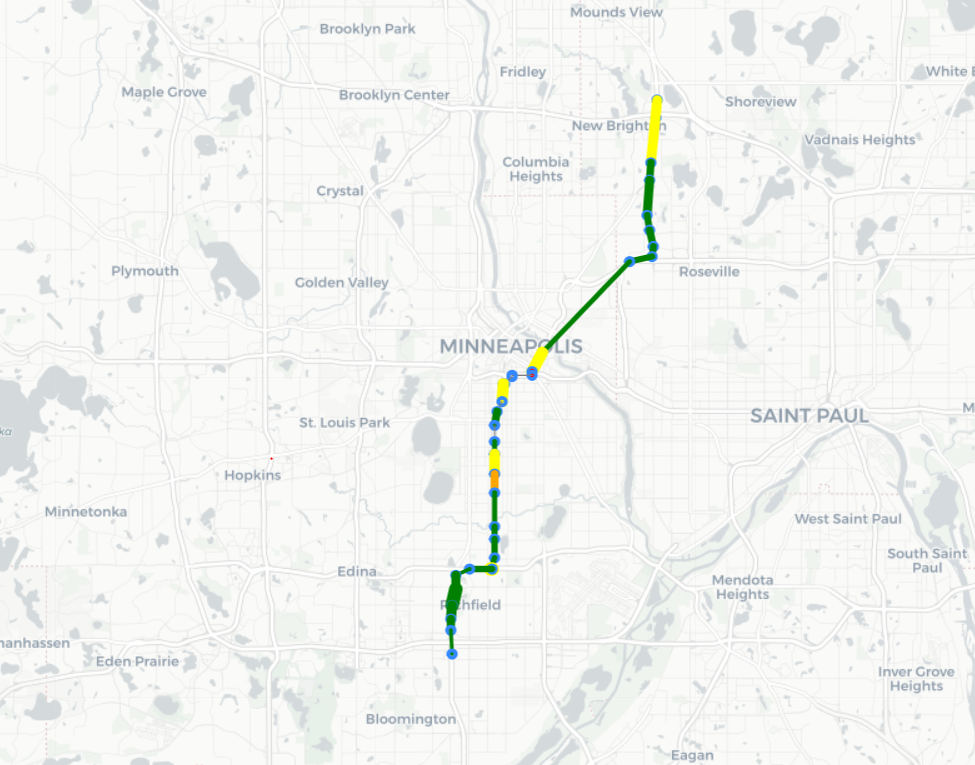

## To view sample images of maps generated, look in the Results folder in Git Hub

#### COPY THIS INTO TERMINAL AT NBpngs Folders NO BRACKETS
------------------------------------------------
#### convert -loop 0 -delay 60 [NBroutemapOct11_16_47_54.png] NBMap.gif


#### COPY THIS INTO TERMINAL AT SBpngs Folders NO BRACKETS
------------------------------------------------
#### convert -loop 0 -delay 60 [SBroutemapOct11_16_47_54.png] SBMap.gif


# Incident Analysis using MNDOT Data

In [29]:
###########################################################################
# Importing Live Data for Incident Analysis
###########################################################################

# Import CSV files into a data frame
Crash_Data_df = pd.read_csv("Data/crash_data_2.csv",encoding='utf-8')
                            
#split date column
Crash_Data_df[["Day", "Month", "DayNum","Time","Zone","Year"]] = Crash_Data_df["Date"].str.split(" ", n = 6, expand = True) 

#define max and min dates
d_max=Crash_Data_df["Date"].min()
d_min=Crash_Data_df["Date"].max()

#split name column
Crash_Data_df[["A","B"]] = Crash_Data_df["Name"].str.split("_|2018100", n = 2, expand = True) 

#Drop time zone
Crash_Data_df.drop(['Zone'], axis = 1, inplace = True)
Crash_Data_df.reset_index(drop=True)

# group by unnamed column
Crash_Data_df = Crash_Data_df.loc[Crash_Data_df['Unnamed: 0'] == 0, :]

#del columns
del Crash_Data_df['Unnamed: 0']
del Crash_Data_df['Name']
del Crash_Data_df['A']

Crash_Data_df = Crash_Data_df.loc[Crash_Data_df['B'] != 9954815, :]

Crash_Data_df = Crash_Data_df.dropna(how='any')
Crash_Data_df.drop_duplicates(subset=['Time'], keep=False)
Crash_Data_df.sort_values(by=['B'])
Crash_Data_df.reset_index(drop=True)
Crash_Data_df = Crash_Data_df.rename(columns={'B':'ID','Date':'DATE','Direction':'DIRECTION','Road':'ROAD','Location':'LOCATION','Event':'EVENT','Day':'DAY','Month':'MONTH','DayNum':'DAYNUM','Time':'TIME','Year':'YEAR'})

Crash_Data_df.set_index('ID', inplace=True,drop=True)

Crash_Data_df.to_csv("Data/crash_data_check.csv", index=False, header=True)
Crash_Data_df.drop_duplicates()

Crash_Data_df.groupby("ID").filter(lambda x: len(x) > 1)

Crash_Data_df.to_csv("Data/crash_data_filtered.csv", index=True, header=True)

######################################################################################################

Crash_Data = "Data/crash_data_filtered.csv"
Crash_Data_df = pd.read_csv(Crash_Data)
Crash_Data_df.drop_duplicates(subset=['DAYNUM'][0], keep=False)
#Crash_Data_df.drop_duplicates(subset=['TIME'], keep=False, inplace=True)
Crash_Data_df.head(3)

######################################################################################################

Crash_Data = "Data/crash_data_filtered.csv"
Crash_Data_df = pd.read_csv(Crash_Data)
Crash_Data_df.head(2)

,ID,DATE,DIRECTION,ROAD,LOCATION,EVENT,DAY,MONTH,DAYNUM,TIME,YEAR
0,9954815,Sun Oct 07 03:35:22 CDT 2018,WB,T.H.62,@ T.H.100 NB,CRASH,Sun,Oct,7,03:35:22,2018
1,9954815,Sun Oct 07 03:35:22 CDT 2018,WB,T.H.62,@ T.H.100 NB,CRASH,Sun,Oct,7,03:35:22,2018


In [22]:
###########################################################################
# BUG WITH MACRO - NEEDS TO BE FIXED STILL

#Crash_Data_df.dtypes
import win32com.client 

run_xl = win32com.client.Dispatch('Excel.Application')
run_xl.Workbooks.Open('Data/CrashDataFilterMacro.xlsm')
run_xl.Application.Run("Macro1")
run_xl.Application.Quit()
 
#PRINT FINAL COMPLETED MESSAGE#
print("Macro refresh completed!")
###########################################################################
# BUG - This needs to be fixed once the macro is fixed.
# right now all the incident visuals are referencing the un-macro'd data
###########################################################################

Crash_Data = "Data/crash_data_filtered.csv"
Crash_Data_df = pd.read_csv(Crash_Data)
Crash_Data_df.head(2)

com_error: (-2147352567, 'Exception occurred.', (0, 'Microsoft Excel', "Sorry, we couldn't find Data/CrashDataFilterMacro.xlsm. Is it possible it was moved, renamed or deleted?", 'xlmain11.chm', 0, -2146827284), None)

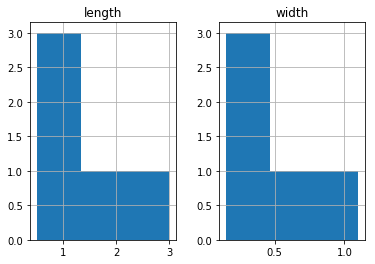

In [30]:
df = pd.DataFrame({
...     'length': [1.5, 0.5, 1.2, 0.9, 3],
...     'width': [0.7, 0.2, 0.15, 0.2, 1.1]
...     }, index= ['pig', 'rabbit', 'duck', 'chicken', 'horse'])
>>> hist = df.hist(bins=3)

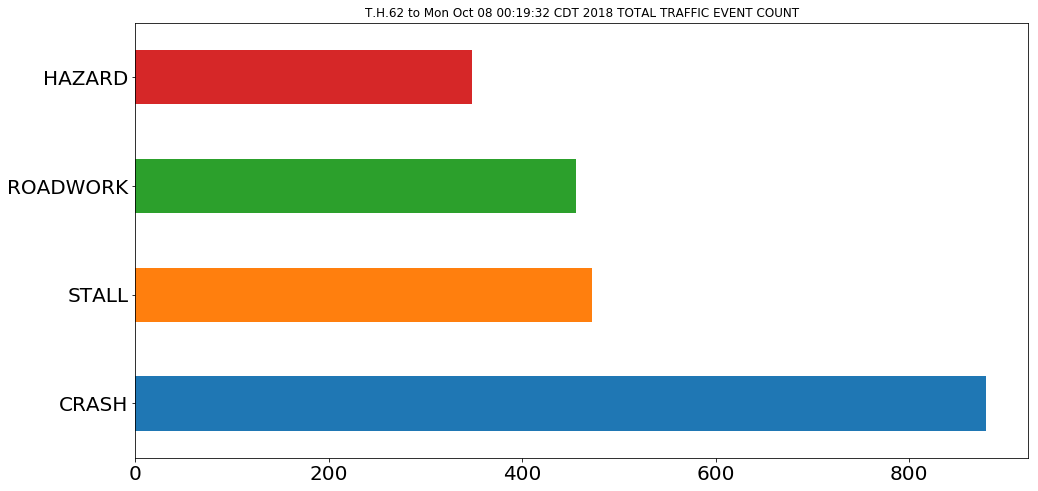

In [31]:
fontsize2use = 15

fontprop = fm.FontProperties(size=fontsize2use)
fig = plt.figure(figsize=(20,10))
plt.xticks(fontsize=fontsize2use)  
plt.yticks(fontsize=fontsize2use)

Crash_Data_df['EVENT'].value_counts().plot(kind='barh',  title=(f'{d_min} to {d_max} TOTAL TRAFFIC EVENT COUNT'), fontsize=20, stacked=True, figsize=[16,8])

plt.savefig("Images/Event_Count_Summary.png")
plt.show()

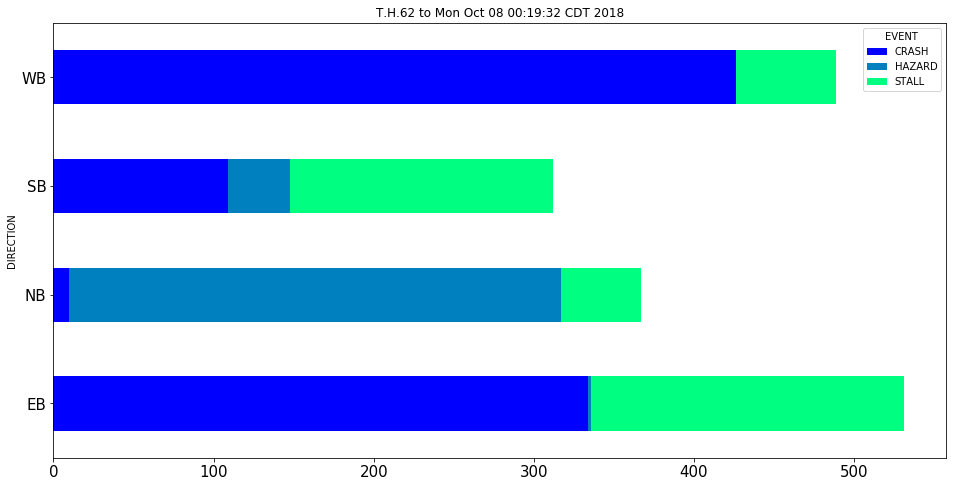

In [32]:
Omit_ROADWORK_Crash_Data_df = Crash_Data_df.loc[Crash_Data_df["EVENT"] != "ROADWORK", :]
flights_by_carrier = Omit_ROADWORK_Crash_Data_df.pivot_table(index='DIRECTION', columns='EVENT', values='DAY', aggfunc='count')
flights_by_carrier.plot(kind='barh', stacked=True,fontsize=15, title=(f'{d_min} to {d_max}'), figsize=[16,8], colormap='winter')

plt.savefig("Images/Crash_Hazards_Stalls_Count.png")

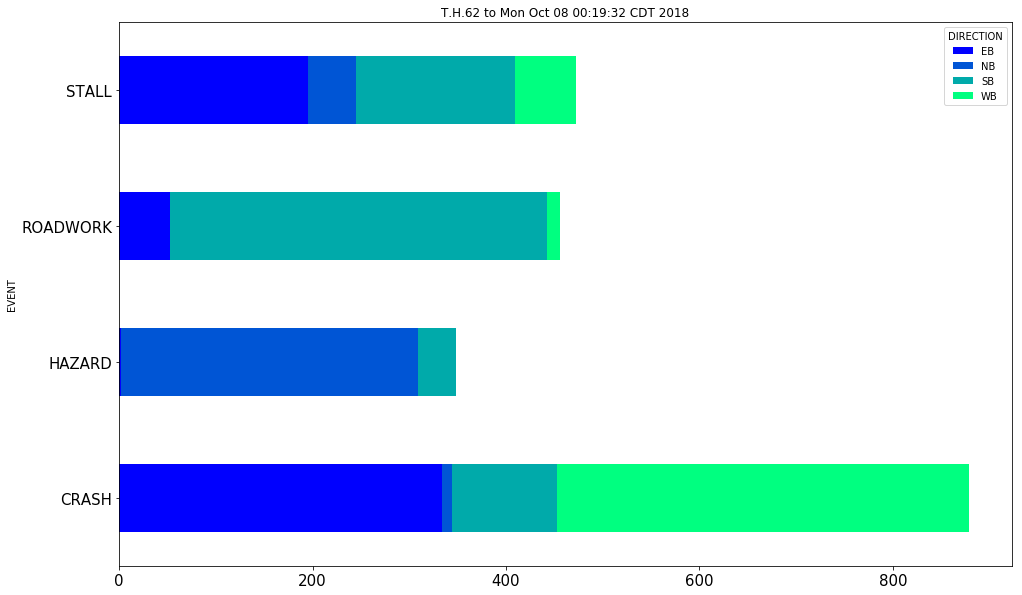

In [26]:
flights_by_carrier = Crash_Data_df.pivot_table(index='EVENT', columns='DIRECTION', values='DAY', aggfunc='count')
flights_by_carrier.plot(kind='barh', stacked=True, title=(f'{d_min} to {d_max}'),fontsize=15, figsize=[16,10], colormap='winter')
plt.savefig("Images/Crash_Hazards_Stalls_by_Direction_Count.png")

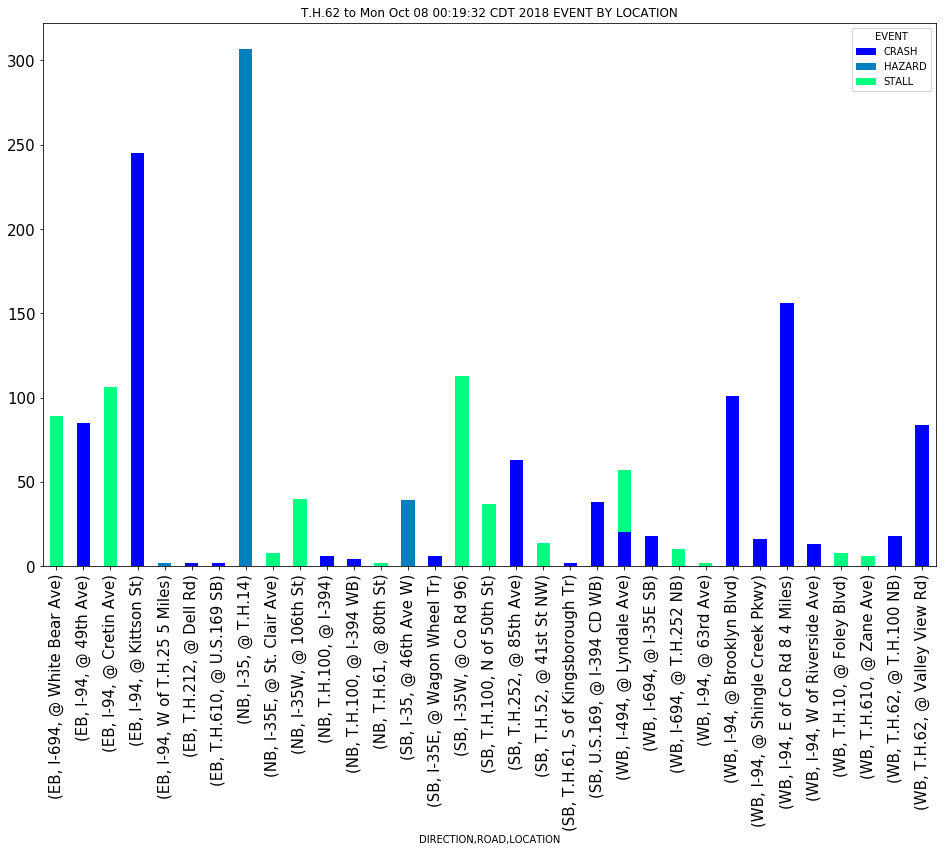

In [27]:
Omit_ROADWORK_Crash_Data_df = Crash_Data_df.loc[Crash_Data_df["EVENT"] != "ROADWORK", :]

group_by_direction_by_event = Omit_ROADWORK_Crash_Data_df.groupby(['DIRECTION','ROAD','LOCATION','EVENT'])

group_by_direction_by_event=group_by_direction_by_event.size().unstack()

group_by_direction_by_event.plot(kind='bar', title=(f'{d_min} to {d_max} EVENT BY LOCATION'), fontsize=15, figsize=[16,10], stacked=True, colormap='winter') # area plot
plt.savefig("Images/Crash_Hazards_Stalls_by_Location_Count.png")

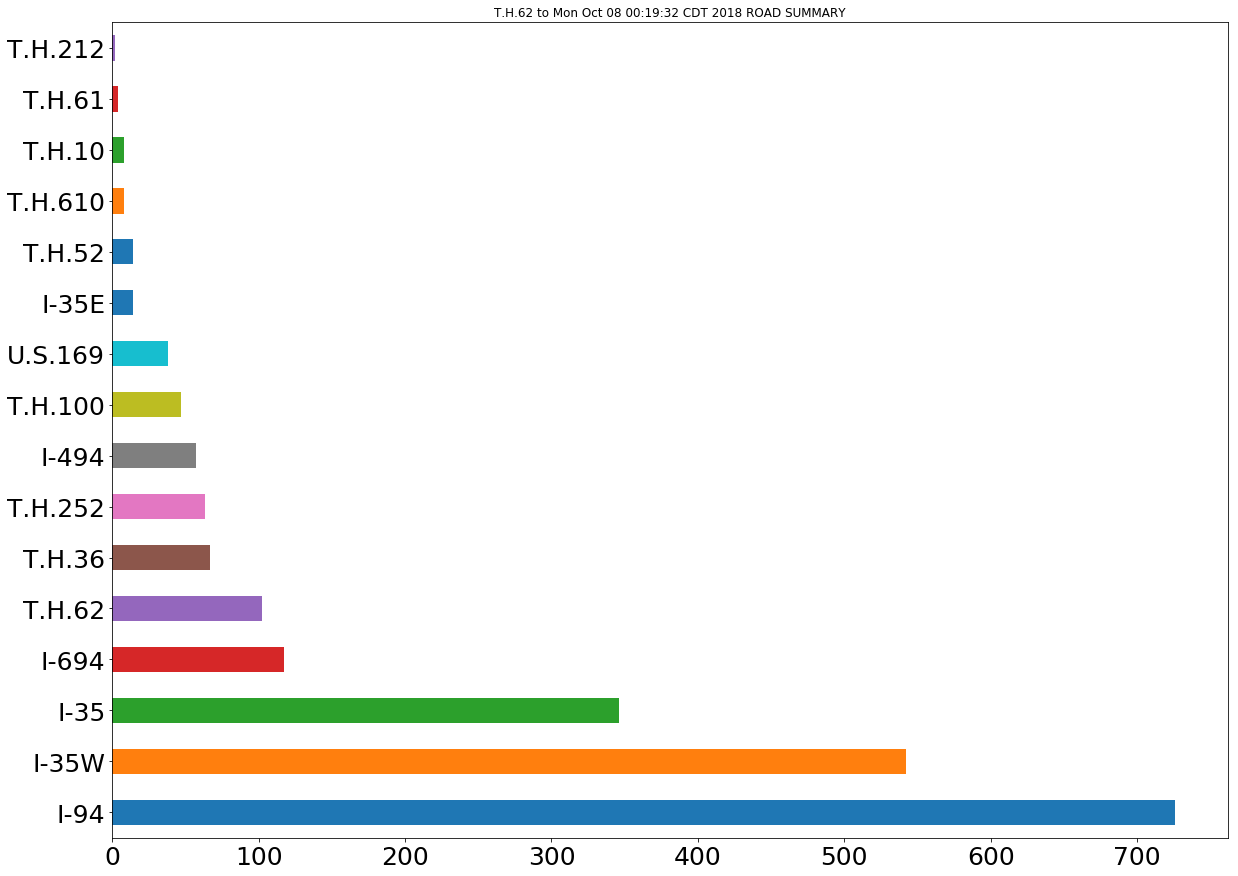

In [28]:
fontsize2use = 25

fontprop = fm.FontProperties(size=fontsize2use)
fig = plt.figure(figsize=(20,15))
plt.xticks(fontsize=fontsize2use)  
plt.yticks(fontsize=fontsize2use)

Crash_Data_df['ROAD'].value_counts().plot(kind='barh',title=(f'{d_min} to {d_max} ROAD SUMMARY'))

plt.savefig("Images/Crash_Hazards_Stalls_by_Road_Count.png")

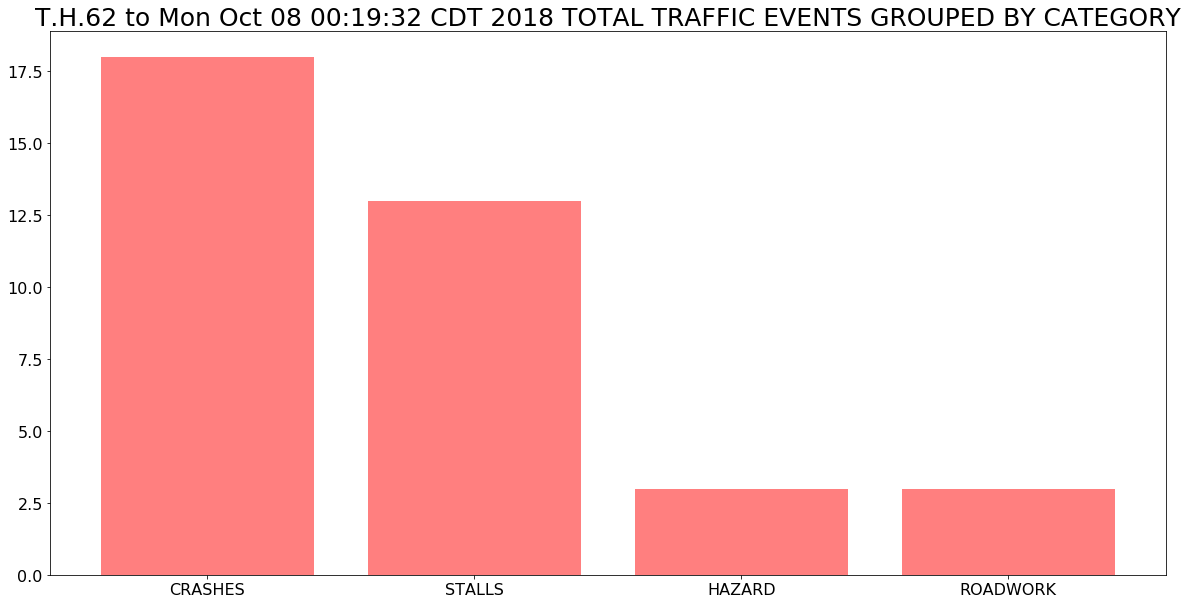

In [29]:
#Filter Event Data for Evenet Summary Chart and Count the Events
Crash_Event = Crash_Data_df.loc[Crash_Data_df["EVENT"] == "CRASH", :]
grouped_Crash_Event = Crash_Event.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Crash_Event = pd.DataFrame(grouped_Crash_Event["EVENT"].count())
Total_CRASHES=len(grouped_Crash_Event)

Hazard_Event = Crash_Data_df.loc[Crash_Data_df["EVENT"] == "HAZARD", :]
grouped_Hazard_Event = Hazard_Event.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Hazard_Event = pd.DataFrame(grouped_Hazard_Event["EVENT"].count())
Total_HAZARDS=len(grouped_Hazard_Event)

Roadwork_Event = Crash_Data_df.loc[Crash_Data_df["EVENT"] == "ROADWORK", :]
grouped_Roadwork_Event =Roadwork_Event.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Roadwork_Event = pd.DataFrame(grouped_Roadwork_Event["EVENT"].count())
Total_ROADWORK=len(grouped_Roadwork_Event)

Stall_Event = Crash_Data_df.loc[Crash_Data_df["EVENT"] == "STALL", :]
grouped_Stall_Event =Stall_Event.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Stall_Event = pd.DataFrame(grouped_Stall_Event["EVENT"].count())
Total_STALLS=len(grouped_Stall_Event)

# use matplotlib to make a bar chart
EVENTS=["CRASHES", "STALLS", "HAZARD", "ROADWORK"]
Event_COUNT=[Total_CRASHES,Total_STALLS,Total_HAZARDS,Total_ROADWORK]

fontsize2use = 16
fontsize3use = 25

fig = plt.figure(figsize=(20,10))
plt.xticks(fontsize=fontsize2use)  
plt.yticks(fontsize=fontsize2use)    
fontprop = fm.FontProperties(size=fontsize2use)

plt.title((f'{d_min} to {d_max} TOTAL TRAFFIC EVENTS GROUPED BY CATEGORY') ,fontsize=fontsize3use)

plt.bar(EVENTS,Event_COUNT, color=('r'), alpha=0.5, align="center")
    
plt.savefig("Images/Crash_By_Event.png")
plt.show()

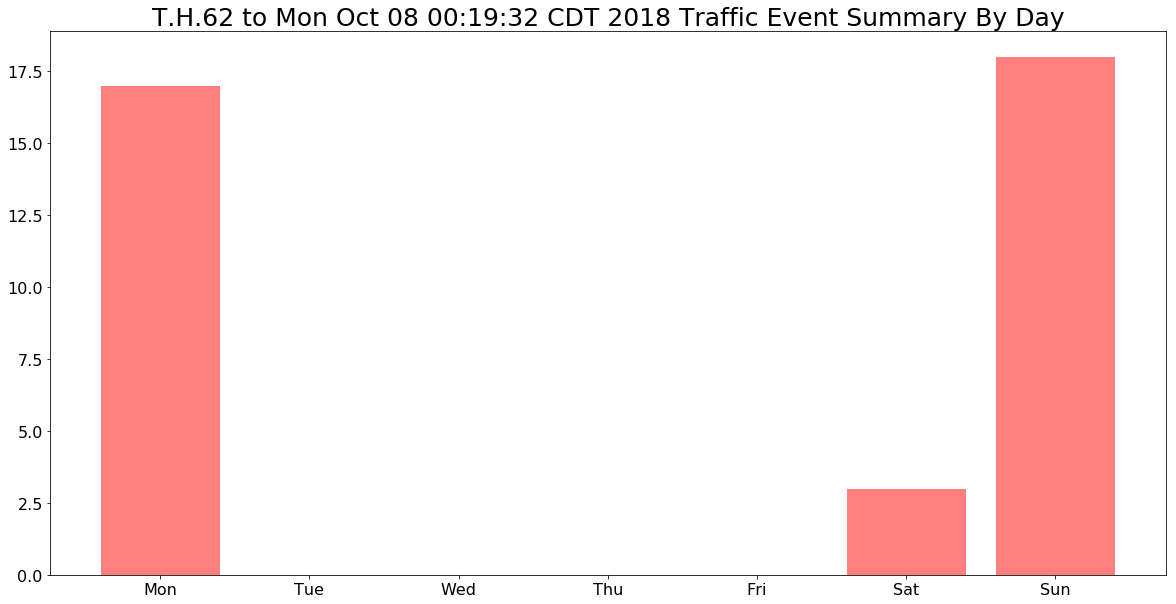

In [30]:
Roadwork_Event = Crash_Data_df.loc[Crash_Data_df["EVENT"] == "ROADWORK", :]
grouped_Roadwork_Event =Roadwork_Event.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Roadwork_Event = pd.DataFrame(grouped_Roadwork_Event["EVENT"].count())
Total_ROADWORK=len(grouped_Roadwork_Event)

#Filter Event Data for Evenet Summary Chart and Count the Events
Crash_Event_Mon = Crash_Data_df.loc[Crash_Data_df["DAY"] == "Mon", :]
grouped_Crash_Event_Mon = Crash_Event_Mon.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Crash_Event_Mon = pd.DataFrame(grouped_Crash_Event_Mon["EVENT"].count())
Total_Mon_CRASHES=len(grouped_Crash_Event_Mon)

Crash_Event_Tue = Crash_Data_df.loc[Crash_Data_df["DAY"] == "Tue", :]
grouped_Crash_Event_Tue = Crash_Event_Tue.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Crash_Event_Tue = pd.DataFrame(grouped_Crash_Event_Tue["EVENT"].count())
Total_Tue_CRASHES=len(grouped_Crash_Event_Tue)

Crash_Event_Wed = Crash_Data_df.loc[Crash_Data_df["DAY"] == "Wed", :]
grouped_Crash_Event_Wed = Crash_Event_Wed.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Crash_Event_Wed = pd.DataFrame(grouped_Crash_Event_Wed["EVENT"].count())
Total_Wed_CRASHES=len(grouped_Crash_Event_Wed)

Crash_Event_Thu = Crash_Data_df.loc[Crash_Data_df["DAY"] == "Thu", :]
grouped_Crash_Event_Thu = Crash_Event_Thu.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Crash_Event_Thu = pd.DataFrame(grouped_Crash_Event_Thu["EVENT"].count())
Total_Thu_CRASHES=len(grouped_Crash_Event_Thu)

Crash_Event_Fri = Crash_Data_df.loc[Crash_Data_df["DAY"] == "Fri", :]
grouped_Crash_Event_Fri = Crash_Event_Fri.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Crash_Event = pd.DataFrame(grouped_Crash_Event_Fri["EVENT"].count())
Total_Fri_CRASHES=len(grouped_Crash_Event_Fri)

Crash_Event_Sat = Crash_Data_df.loc[Crash_Data_df["DAY"] == "Sat", :]
grouped_Crash_Event_Sat = Crash_Event_Sat.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Crash_Event_Sat = pd.DataFrame(grouped_Crash_Event_Sat["EVENT"].count())
Total_Sat_CRASHES=len(grouped_Crash_Event_Sat)

Crash_Event_Sun = Crash_Data_df.loc[Crash_Data_df["DAY"] == "Sun", :]
grouped_Crash_Event_Sun = Crash_Event_Sun.groupby(['ROAD','LOCATION','DIRECTION'])
grouped_Crash_Event_Sun = pd.DataFrame(grouped_Crash_Event_Sun["EVENT"].count())
Total_Sun_CRASHES =len(grouped_Crash_Event_Sun)

# use matplotlib to make a bar chart of crash data by location
EVENTS_BY_DAY=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
Event_COUNT=[Total_Mon_CRASHES,Total_Tue_CRASHES,Total_Wed_CRASHES,
             Total_Thu_CRASHES,Total_Fri_CRASHES,Total_Sat_CRASHES,Total_Sun_CRASHES]

fontsize2use = 16
fontsize3use = 25

fig = plt.figure(figsize=(20,10))
plt.xticks(fontsize=fontsize2use)  
plt.yticks(fontsize=fontsize2use)    
fontprop = fm.FontProperties(size=fontsize2use)

plt.title((f'{d_min} to {d_max} Traffic Event Summary By Day') ,fontsize=fontsize3use)

plt.bar( EVENTS_BY_DAY,Event_COUNT, color=('r'), alpha=0.5, align="center")
  
plt.savefig("Images/Crash_By_Event_By_Day.png")

plt.show()

Crash count by days :2


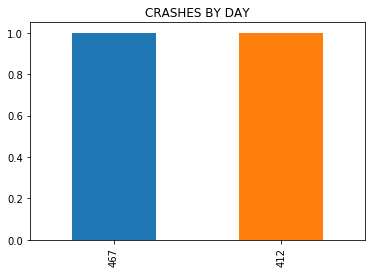

In [31]:
Crash_data_by_day = Crash_Data_df[Crash_Data_df['EVENT'] == 'CRASH']
Crash_count=Crash_data_by_day['DAY'].value_counts()
Crash_days=len(Crash_data_by_day['DAY'].value_counts())
print(f'Crash count by days :{Crash_days}')

Crash_data_by_day['DAY'].value_counts().value_counts().plot(kind='bar', title='CRASHES BY DAY')

plt.savefig("Images/Crash_Count_By_Day.png")


Roadwork count by days :2


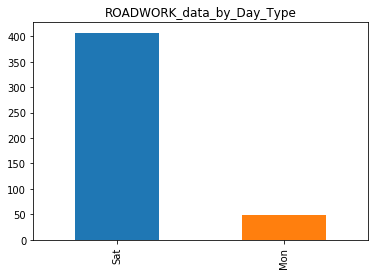

In [32]:
Roadwork_data_by_day= Crash_Data_df[Crash_Data_df['EVENT'] == 'ROADWORK']
Roadwork_Count=Roadwork_data_by_day['DAY'].value_counts()
Roadwork_days=len(Crash_data_by_day['DAY'].value_counts())
print(f'Roadwork count by days :{Roadwork_days}')


Roadwork_data_by_day['DAY'].value_counts().plot(kind='bar', title='ROADWORK_data_by_Day_Type')
plt.savefig("Images/Roadwork_Count_By_Day.png")

Stall count by days : 13


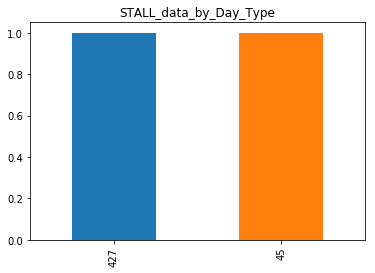

In [33]:
Stall_data_by_day= Crash_Data_df.loc[Crash_Data_df["EVENT"] == "STALL", :]
grouped_Stall_Event =Stall_Event.groupby(["ROAD","LOCATION","DIRECTION"])
grouped_Stall_Event = pd.DataFrame(grouped_Stall_Event["EVENT"].count())
Stall_days=len(grouped_Stall_Event)
print(f'Stall count by days : {Stall_days}')

Stall_data_by_day['DAY'].value_counts().value_counts().plot(kind='bar', title='STALL_data_by_Day_Type')
plt.savefig("Images/Stall_Count_By_Day.png")

Hazard count by days : 2


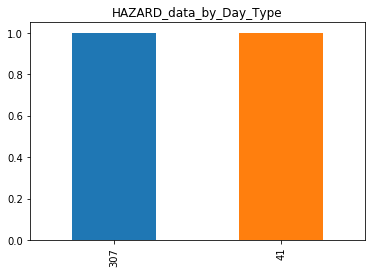

In [34]:
Hazard_data_by_day= Crash_Data_df[Crash_Data_df['EVENT'] == 'HAZARD']
Hazard_Count=Hazard_data_by_day['DAY'].value_counts()
Hazard_days=len(Crash_data_by_day['DAY'].value_counts())

print(f'Hazard count by days : {Hazard_days}')

Hazard_data_by_day['DAY'].value_counts().value_counts().plot(kind='bar', title='HAZARD_data_by_Day_Type')
plt.savefig("Images/Hazard_Count_By_Day.png")

# 35W Traffic Flow Analysis from 694 to 494

In [35]:
###########################################################################
# Read CSV Files
###########################################################################

# Sensor names, labels for SB 35W from 694 to 494
sensor_list = 'Station_Keys/Southbound_35W_StationNames.csv'
SensorList = pd.read_csv(sensor_list)
SensorDF = pd.DataFrame(SensorList)

# Oct_data from a single day showing SB 35W Traffic
oct_data = ('Archived_Data_MNDOT/SB35W_Oct_3_18_Volume_Sum_RushHours.csv')
Oct_cvs = pd.read_csv(oct_data)
OctDF = pd.DataFrame(Oct_cvs)

#Sensor names, labels for NB 35W from 494 to 694
nbsensor_list = 'Station_Keys/Northbound_35W_StationNames.csv'
nbSensorList = pd.read_csv(nbsensor_list)
NBSensorDF = pd.DataFrame(nbSensorList)

# Oct_data from a single day showing NB 35W Traffic
nboct_data = 'Archived_Data_MNDOT/NB35W_Oct_3_18_Volume_Sum_RushHours.csv'
nboct_csv = pd.read_csv(nboct_data)
NBOctDF = pd.DataFrame(nboct_csv)

mpls_csv = 'Station_Keys/MPLS_Route_StationNames.csv'
mpls_csvR = pd.read_csv(mpls_csv)
mpls_DF = pd.DataFrame(mpls_csvR)


mpls_data_csv = 'Archived_Data_MNDOT/MPLS_Entry_Exit_Volume_SpecificDates_2.csv'
dtypes = {'col1': 'str', 'col2': 'str', 'col3': 'str', 'col4': 'str', 'col5':'str', 'col6':'float', 'col7':'float'}
parse_dates = ['Date']
mpls_data = pd.read_csv(mpls_data_csv, sep=',', dtype=dtypes, parse_dates=parse_dates)
mpls_dataDF = pd.DataFrame(mpls_data)

###########################################################################
# Merge CSV Files to create South Bound 35W Data (SB_Data)
###########################################################################

#Merged SB 35W Data and Labels
SB_Data = pd.merge(SensorDF, OctDF, how = 'left', on = '1')

#Merged NB 35W Data and Labels
NB_Data = pd.merge(NBSensorDF, NBOctDF, how = 'left', on = '1')

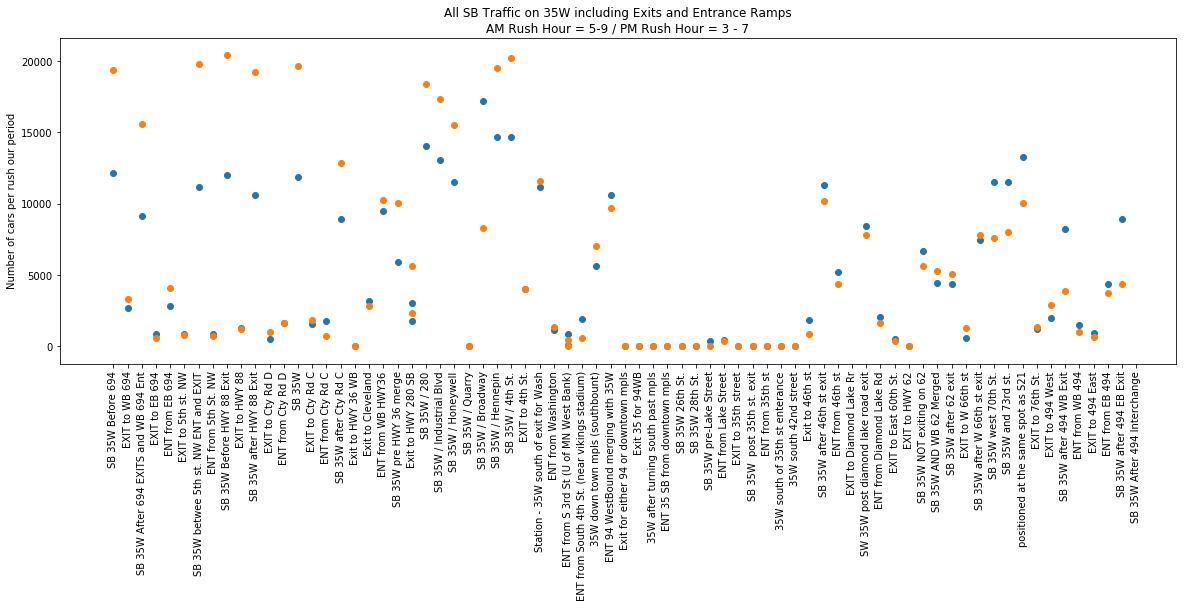

In [6]:
###########################################################################
# SOUTHBOUND TRAFFIC SHOWING FLOW, ON AND OFF RAMPS
###########################################################################

y1 = SB_Data['AM Rush']
y2 = SB_Data['PM Rush']
X_Axis = SB_Data['Label']

# Figure Settings
plt.figure(figsize=(20,6))
plt.xticks(rotation=90)

# Figure Labels
plt.title("All SB Traffic on 35W including Exits and Entrance Ramps\nAM Rush Hour = 5-9 / PM Rush Hour = 3 - 7")
plt.ylabel("Number of cars per rush our period")

# Scatter Plot
plt.scatter(X_Axis, y1)
plt.scatter(X_Axis, y2)

plt.show()

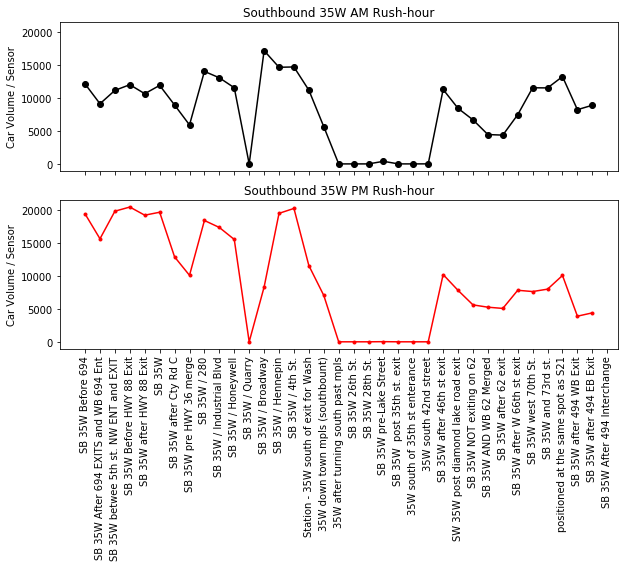

In [7]:
###########################################################################
# SOUTHBOUND 35W TRAFFIC - FLOW ONLY
###########################################################################
SB35W_Flow = SB_Data.loc[SB_Data['Type']=='Flow']

# Inputs
y1 = SB35W_Flow ['AM Rush']
y2 = SB35W_Flow['PM Rush']
x1 = SB35W_Flow['Label']
x2 = SB35W_Flow['Label']

# Create two subplots sharing y axis
fig, (ax1, ax2) = plt.subplots(2, sharex = True, sharey=True, figsize=(10,6))

# AM Rush-hour
ax1.plot(x1, y1, 'ko-')
ax1.set(title='Southbound 35W AM Rush-hour', ylabel='Car Volume / Sensor')

# PM Rush-hour
ax2.plot(x2, y2, 'r.-')
ax2.set(title='Southbound 35W PM Rush-hour', ylabel='Car Volume / Sensor')

# Rotate xticks (reminder both images are sharing the X-axis labels)
plt.xticks(rotation=90)

plt.show()

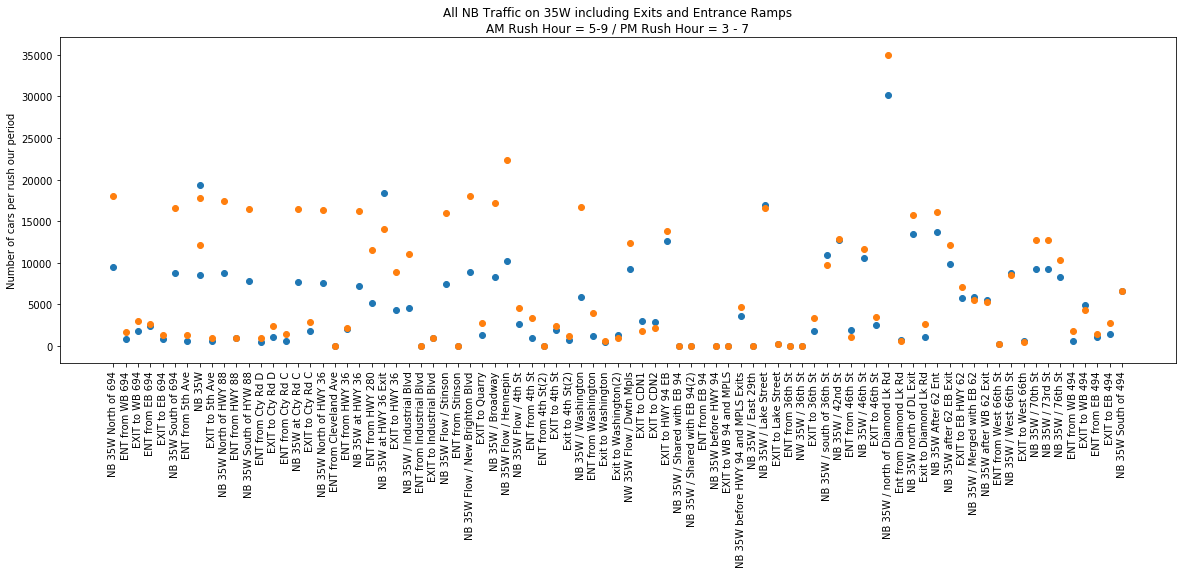

In [8]:
###########################################################################
# NORTHBOUND TRAFFIC SHOWING FLOW, ON AND OFF RAMPS
###########################################################################

y1 = NB_Data['AM_RushHour']
y2 = NB_Data['PM_RushHour']
X_Axis = NB_Data['Label']

# Figure Settings
plt.figure(figsize=(20,6))
plt.xticks(rotation=90)

# Figure Labels
plt.title("All NB Traffic on 35W including Exits and Entrance Ramps\nAM Rush Hour = 5-9 / PM Rush Hour = 3 - 7")
plt.ylabel("Number of cars per rush our period")

# Scatter Plot
plt.scatter(X_Axis, y1)
plt.scatter(X_Axis, y2)

plt.show()

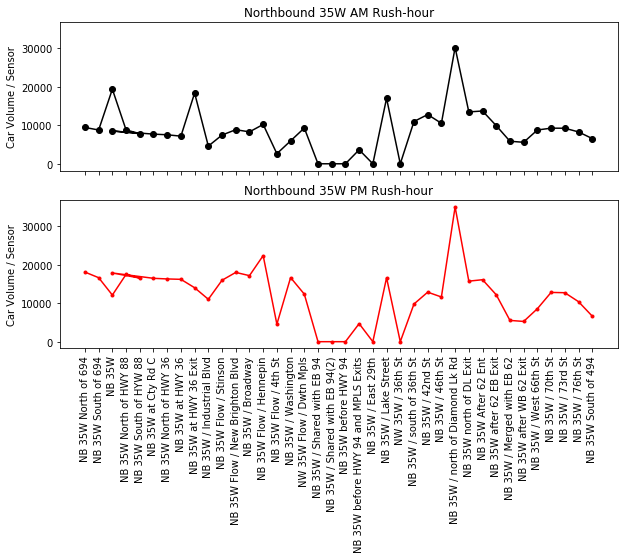

In [9]:
###########################################################################
# NORTHBOUND 35W TRAFFIC - FLOW ONLY
###########################################################################

NB35W_Flow = NB_Data.loc[NB_Data['Type']=='Flow']

# Inputs
y1 = NB35W_Flow ['AM_RushHour']
y2 = NB35W_Flow['PM_RushHour']
x1 = NB35W_Flow['Label']
x2 = NB35W_Flow['Label']

# Create two subplots sharing y axis
fig, (ax1, ax2) = plt.subplots(2, sharex = True, sharey=True, figsize=(10,6))

# AM Rush-hour
ax1.plot(x1, y1, 'ko-')
ax1.set(title='Northbound 35W AM Rush-hour', ylabel='Car Volume / Sensor')

# PM Rush-hour
ax2.plot(x2, y2, 'r.-')
ax2.set(title='Northbound 35W PM Rush-hour', ylabel='Car Volume / Sensor')

# Rotate xticks (reminder both images are sharing the X-axis labels)
plt.xticks(rotation=90)

plt.show()

In [10]:
###########################################################################
# Identify 35W Southbound EXITS WITH HIGHEST volume of traffic
###########################################################################

SB35W_Exits = SB_Data.loc[SB_Data['Type']!='Flow']
SB35W_ExitsDF = SB35W_Exits[['Label', 'Type', 'AM Rush']]
SB35W_ExitsHigh = SB35W_ExitsDF.sort_values(by='AM Rush', ascending=False).head(5)

SB35W_ExitsDFpm = SB35W_Exits[['Label', 'Type', 'PM Rush']]
SB35W_ExitsHighpm = SB35W_ExitsDFpm.sort_values(by='PM Rush', ascending=False).head(5)

display_side_by_side(SB35W_ExitsHigh, SB35W_ExitsHighpm)

,Label,Type,AM Rush
37,ENT 94 WestBound merging with 35W,On,10594.0
19,ENT from WB HWY36,On,9510.0
53,ENT from 46th st,On,5214.0
72,ENT from EB 494,On,4377.0
30,EXIT to 4th St.,Exit,4012.0
,Label,Type,PM Rush
19,ENT from WB HWY36,On,10265.0
37,ENT 94 WestBound merging with 35W,On,9691.0
22,Exit to HWY 280 SB,Exit,5616.0
53,ENT from 46th st,On,4369.0


In [11]:
###########################################################################
# Identify 35W Northbound EXITS WITH HIGHEST volume of traffic
###########################################################################

NB35W_Exits = NB_Data.loc[NB_Data['Type']!='Flow']
NB35W_ExitsDF = NB35W_Exits[['Label', 'Type', 'AM_RushHour']]
NB35W_ExitsHigh = NB35W_ExitsDF.sort_values(by='AM_RushHour', ascending=False).head(5)

NB35W_ExitsDFpm = NB35W_Exits[['Label', 'Type', 'PM_RushHour']]
NB35W_ExitsHighpm = NB35W_ExitsDFpm.sort_values(by='PM_RushHour', ascending=False).head(5)

display_side_by_side(NB35W_ExitsHigh, NB35W_ExitsHighpm)

,Label,Type,AM_RushHour
46,EXIT to HWY 94 EB,Exit,12572.0
70,EXIT to EB HWY 62,Exit,5771.0
22,ENT from HWY 280,On,5150.0
80,EXIT to WB 494,Exit,4990.0
24,EXIT to HWY 36,Exit,4317.0
,Label,Type,PM_RushHour
46,EXIT to HWY 94 EB,Exit,13824.0
22,ENT from HWY 280,On,11584.0
24,EXIT to HWY 36,Exit,8880.0
70,EXIT to EB HWY 62,Exit,7072.0


# Analysis of MPLS Entry/Exit Points

## 35W, 94, and 394

In [12]:
###########################################################################
# Packers at Vikings 10/15/2017
###########################################################################

VikPak_DF = mpls_dataDF.loc[mpls_dataDF['Event Label']=='Packers at Vikings']
VikPak = VikPak_DF[['Volume', 'St Label', 'Direction', 'Freeway Tag']]
VikPak_to = VikPak.loc[VikPak['Direction']=='To']
VikPak_Tosorted = VikPak_to.sort_values(by = 'Freeway Tag', ascending = True)

VikPak_From = VikPak.loc[VikPak['Direction']=='From']
VikPak_Fromsorted = VikPak_From.sort_values(by='Freeway Tag', ascending = True)
display_side_by_side(VikPak_Tosorted, VikPak_Fromsorted)

,Volume,St Label,Direction,Freeway Tag
61,28958,EB 94 to dwtn,To,1
69,33427,NB 35W to dwtn,To,2
64,48752,EB 394 to dwtn,To,3
65,57976,WB 94 to dwtn,To,4
68,53712,SB 35W to dwtn,To,5
,Volume,St Label,Direction,Freeway Tag
60,28521,WB 94 from dwtn,From,1
62,37519,SB 35W from dwtn,From,2
63,47075,WB 394 from dwtn,From,3
66,57503,EB 94 from dwtn,From,4


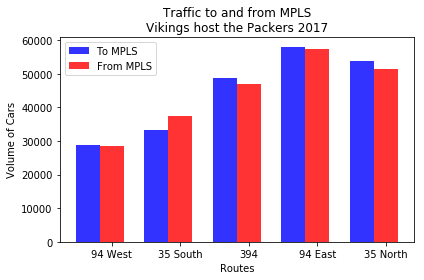

In [13]:
###########################################################################
#Visualization of Vikes Pac game 2017
###########################################################################

n_groups = 5
VikPak_trafficTo = list(VikPak_Tosorted['Volume'])
VikPak_TrafficFr = list(VikPak_Fromsorted['Volume'])

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, VikPak_trafficTo, bar_width,
                alpha = opacity,
                color = 'b',
                label = 'To MPLS')
rects2 = plt.bar(index+bar_width, VikPak_TrafficFr, bar_width,
                alpha = opacity,
                color = 'r',
                label = 'From MPLS')

plt.xlabel('Routes')
plt.ylabel('Volume of Cars')
plt.title('Traffic to and from MPLS\nVikings host the Packers 2017')
plt.xticks(index + bar_width, ('94 West', '35 South', '394', '94 East', '35 North'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
###########################################################################
#Interactive Visualizations for 10 different data sets
###########################################################################

sensor_out=["S2","S569","S285","S554","S125"]
sensor_in=["S64","S582","S286","S553","S137"]

def plot_flow_event(b):
    Num_of_event=events.index(b)
    aa=EE_df.groupby(["Event Label"]).get_group(b).sort_values(by="road");
    #aa=aa[aa["road"]=="35W"]
    aa.set_index("Sensor",inplace=True)
    sensors_in=aa.loc[sensor_in,"name_sensor"]
    sensors_out=aa.loc[sensor_out,"name_sensor"]
    flow_in=aa.loc[sensor_in,"Volume"]
    flow_out=aa.loc[sensor_out,"Volume"]
    
    
    fig, ax = plt.subplots(figsize=(15,5))
    opacity=0.8
    bar_width = 0.35
    index = np.arange(5)

    rects1 = plt.bar(index, flow_in, bar_width,
                alpha = opacity,
                color = 'b',
                label = 'To MPLS')
    rects2 = plt.bar(index+bar_width, flow_out, bar_width,
                alpha = opacity,
                color = 'r',
                label = 'From MPLS')

    print(index)
    print(sensors_in.values)
#     fig, ax = plt.subplots(figsize=(15,5))
#     ax.bar(aa["Sensor"],aa["Volume"])
    #ax.set_xticklabels(index,tuple(sensors_in.values))
    #plt.set_xticklabels(position=[(1.,0),(2.,0)],labels=["A","B"])
    #ax.set_xticklabels(index+bar_width,aa["sensor_fromto"],rotation=45,ha="right")
    
    #plt.set_ylabel("vehicle flow")
    #plt.set_title(f"Traffic to and from MPLS\n{b}")
    #plt.legend()
    
    plt.xlabel('Routes')
    plt.ylabel('Volume of Cars')
    plt.title(f"Traffic to and from MPLS\n{b}")
    plt.xticks(index + bar_width, ('35W_SB(in)', '35W_NB(in)', '394WB(in)', '94WB(in)', '94WB(in)'))
    plt.legend()
    return None
w1=dict(b=widgets.Dropdown(options=events,value=events[0],description='event',disabled=False))
output = interactive_output(plot_flow_event, w1)
box = VBox([*w1.values(), output])
display(box)
#plot_flow_event("October Wed 2018")

In [14]:
###########################################################################
# Clean up data to determine route direction
###########################################################################

try:
    ls=[EE_df]
    del EE_df
    del ls
except  NameError:
     pass

EE_df=pd.read_csv("./Archived_Data_MNDOT/MPLS_Entry_Exit_Volume_SpecificDates.csv")

# len(EE_df)
# set(list(EE_df["Sensor"].values))
# EE_df.columns
def modi_Twins_Opener(x):
    try:
        if (x.split()[1]=="Twins")and(x.split()[2]=="Opener"):
            return '2018 Twins Opener'
        else:
            return x
    except:
        return x
            
    
EE_df["Event Label_2"]=EE_df["Event Label"].apply(modi_Twins_Opener);
EE_df.drop(columns=["Event Label"],inplace=True);
EE_df.rename(columns={"Event Label_2":"Event Label"},inplace=True);

#EE_df.set_index(["Event Label","Sensor"]);
def FromOrTodowntown(x):
    def fromto(y):
        if y=="from":
            return "out"
        else:
            return "in"
    return fromto(x.split()[-2])
def road(x):
    a=list(x.split())[0:2]
    return ' '.join(a[::-1])

EE_df["Direction(from/to)"]=EE_df["St Label"].apply(FromOrTodowntown);
EE_df["road"]=EE_df["St Label"].apply(road);

EE_df.head();
events=list(EE_df["Event Label"].unique());
events=list(EE_df["Event Label"].unique());

EE_df["sensor_name"]=EE_df["Sensor"]+'('+EE_df["road"]+")";
sensors=list(EE_df["sensor_name"].unique())

EE_df["name_sensor"]=EE_df["road"]+'('+EE_df[ "Sensor"]+")";


sensors=list(EE_df["sensor_name"].unique());
sensors2=list(EE_df["name_sensor"].unique());
len(events);
EE_df["sensor_fromto"]=EE_df["road"]+","+EE_df["Sensor"]+','+EE_df["Direction(from/to)"];
EE_df;

In [15]:
###########################################################################
# 
###########################################################################

#https://github.com/jupyter-widgets/ipywidgets/issues/1582
from IPython.display import display
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt

def plot_flow_event(b):
    Num_of_event=events.index(b)
    aa=EE_df.groupby(["Event Label"]).get_group(b).sort_values(by="road");
    #aa=aa[aa["road"]=="35W"]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(aa["Sensor"],aa["Volume"])
    ax.set_xticklabels(aa['road'])
    ax.set_ylabel("vehicle flow")
    ax.set_title(b)

w1=dict(b=widgets.Dropdown(options=events,value=events[0],description='event',disabled=False))

output = interactive_output(plot_flow_event, w1)
box = VBox([*w1.values(), output])
display(box)

In [16]:
###########################################################################

###########################################################################

def plot_flow_sensor(b):
    Num_of_sensor=sensors.index(b)
    aa=EE_df.groupby(["sensor_name"]).get_group(b).sort_values(by="Event Label");
    #aa=aa[aa["road"]=="35W"]
    fig, ax = plt.subplots(figsize=(15,3))
    ax.bar(aa["Event Label"],aa["Volume"])
    ax.set_xticklabels(aa["Event Label"],rotation=45,ha="right")
    ax.set_ylabel("vehicle flow")
    ax.set_title(b)

w2=dict(b=widgets.Dropdown(options=sensors,value=sensors[0],description='Sensor',disabled=False))

output = interactive_output(plot_flow_sensor, w2)
box = VBox([*w2.values(), output])
display(box)

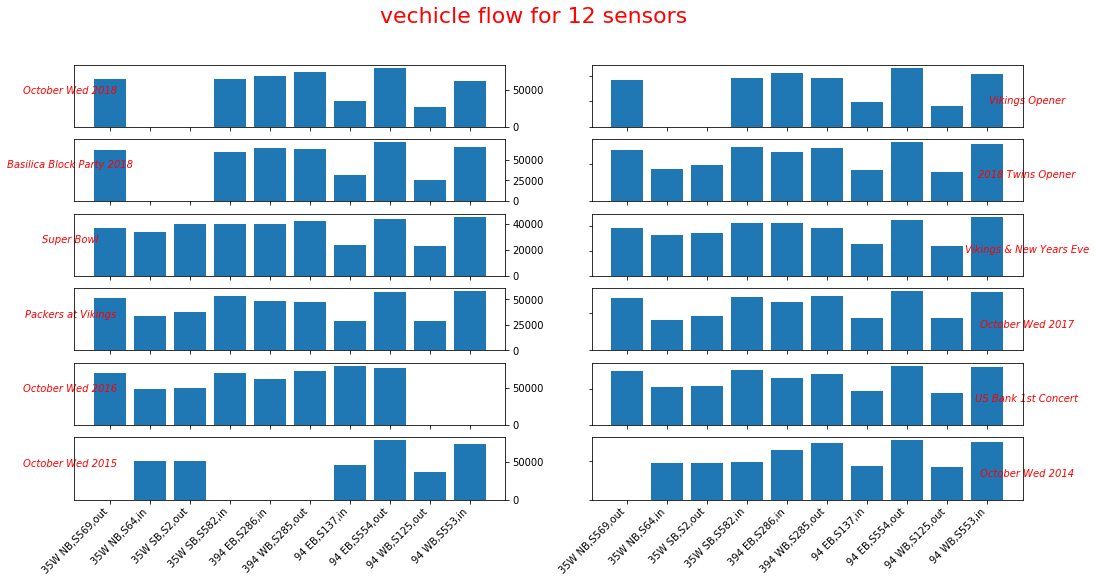

In [17]:
###########################################################################

###########################################################################

def plot_flow_event_all(b,ax):
    Num_of_event=events.index(b)
    b1,b2=(int(Num_of_event/2),Num_of_event%2)
    aa=EE_df.groupby(["Event Label"]).get_group(b).sort_values(by="road");
    #aa=aa[aa["road"]=="35W"]
    #fig, ax = plt.subplots(figsize=(15,5))
    ax[b1,b2].bar(aa["Sensor"],aa["Volume"])
    ax[b1,b2].set_xticklabels(aa["sensor_fromto"],rotation=45,ha="right")
    if (b2==0):
        ax[b1,b2].yaxis.tick_right()
        #ax[b1,b2].set_ylabel(b,rotation=0)
        
        box = ax[b1,b2].get_position()
        #ax[b1,b2].set_ylabel(b,rotation=45,fontstyle='oblique',position=(box.x0-box.width*0.4,box.y0))
        #ax[b1,b2].text(box.x0+box.width*0.4,box.y0,b,rotation=45,fontstyle='oblique')
        ax[b1,b2].set_ylabel(b,rotation=0,fontstyle='oblique')
        ax[b1,b2].yaxis.label.set_color('red')
    else:
        ax[b1,b2].set_yticklabels('')
        ax[b1,b2].yaxis.set_label_position("right")
        ax[b1,b2].set_ylabel(b,rotation=0,fontstyle='oblique')
        ax[b1,b2].yaxis.label.set_color('red')
    #ax[b1,b2].set_yticklabels(aa['road'],rotation=45,ha="right")
    
    
    #ax[b1,b2].set_title(b)
    #leg[b1,b2]=ax[b1,b2].set_label(b)
    return None
fig, ax = plt.subplots(6,2,sharex='all',figsize=(17,8))

# leg=np.zeros((6,2))
for b in events:
    plot_flow_event_all(b,ax)
title=fig.suptitle("vechicle flow for 12 sensors",fontsize=22,color="red")
#fig.legend(loc="right")
#fig.legend((leg[0,0],leg[0,1]), ('Line 1', 'Line 2'), 'upper left')
# box = ax[3,1].get_position()
# pos=ax[].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# # Put a legend to the right of the current axis
# leg=ax1.legend(loc='upper left', bbox_to_anchor=(1, 1.0))